Import libraries

In [2]:
import os
import re
import gzip
import json
import random
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Install and download nltk resources (if needed)
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

from sklearn.decomposition import LatentDirichletAllocation

from transformers import pipeline

Setting the current working directory

In [3]:
script_directory = os.getcwd()
os.chdir(script_directory)

Load data

In [13]:
# Specify the path to JSON Lines file
file_path = 'Arxiv_data/arxiv-abstracts.jsonl.gz'

# Setting seed for reproducibility
random.seed(42)

# Open the gzipped JSON Lines file
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    # Read a random subset of abstracts
    sample_size = 500000  
    # Load JSON lines into a list of dictionaries
    data = [json.loads(line) for line in random.sample(file.readlines(), sample_size)]

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print("Preview of the DataFrame:")
print(df.head())

# Display the shape of the DataFrame
print("DataFrame shape:", df.shape)

(500000, 11)


Function to encode abstracts with 'dates'

In [ ]:
# Extract publication dates from arXiv IDs and create a new 'publication_date' column
def extract_date(x):
    # Use regular expression to extract the year and month from the arXiv ID
    year_month = re.search(r'(\d{2})(\d{2})', x)
    if year_month:
        # Unpack the groups and create a datetime object with the year and month
        year, month = year_month.groups()
        return datetime.strptime(f"{year}-{month}-01", "%y-%m-%d")
    else:
        return None
    
# Apply the extract_date function to the 'id' column and create a new 'publication_date' column
df['publication_date'] = df['id'].apply(extract_date)

# Display the first few rows of the DataFrame with the new 'publication_date' column
print("DataFrame with publication dates:")
print(df.head())

Sort the dataframe wrt. publication 'date'

In [6]:
# Sort the DataFrame in descending order based on 'publication_date'
df_sorted = df.sort_values(by='publication_date', ascending=False)

df_sorted.head()

## Topic Modelling with Latent Dirichlet Analysis (LDA) on abstracts from articles published during COVID-19

The data was initially subsetted to correspond to the timeframe of the COVID-19 pandemic

In [24]:
# Subset the sorted DataFrame based on the COVID-19 period feb. 2020 - dec 2021
df_covid = df_sorted[(df_sorted['publication_date'] >= '2020-02-01')]

df_covid.head()
df_covid.tail()

df_covid.shape

(87194, 12)

1. Data preprocessing

In [10]:
# Extracting abstracts
abstracts = df_covid['abstract'].tolist()

# Set seed for reproducability
random.seed(42)
# Shuffle the abstracts for variety
random.shuffle(abstracts)

# Load lemmatizer
lemmatizer = WordNetLemmatizer()                # The process of lemmatization reduces words to their base or root form (Grouping together different forms of the same word).
stop_words = set(stopwords.words('english'))    # Common words are removed as they often does not contribute the overall meaning of the text.

# Process each abstract by tokenizing, lemmatizing, and removing stop words - resulting in the cleaned_abstracts list containing the cleaned documents.
cleaned_abstracts = []
for abstract in abstracts:
    # Tokenize and lemmatize
    tokens = word_tokenize(abstract.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()] #isalnum checks whether all characters in the token are alphanumeric. Helps filter out tokens that may contain non-alphanumeric characters before lemmatizing 
    # Remove stop words
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    cleaned_abstracts.append(' '.join(filtered_tokens))

# Visualize som cleaned abstacts
print("Example cleaned abstracts:")
for i in range(2):
    print(f"Abstract {i + 1}: {cleaned_abstracts[i]}")

# Utilizing CountVectorizer() to create a Bag of Words matrix (X)
# Each row represents an abstract, and each column represents a unique word in the vocabulary.
# The cells represent the counts of each word in the corresponding abstract.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_abstracts)

Example cleaned abstracts:
Abstract 1: technical report contains material accompanying work title published start sec 1 detailed presentation core innovation work await model checking amc correctness proof amc found sec next discus three study case sec 3 presenting bug found challenge encountered applying vsync existing code base finally sec 4 describe setup detail evaluation report experimental result
Abstract 2: autonomous navigation key skill assistive service robot successful robot minimise disruption caused human moving implies predicting people move complying social convention avoiding disrupting personal space people path interaction example social convention paper leverage graph neural network model robot disruption considering movement human robot model built used path planning algorithm along model paper present evolution dataset socnav1 25 considers movement robot human updated transformation tested using different graph neural network block model trained achieves performanc

2. Dimensionality reduction

In [11]:
print(f'Shape after filtering: {X.shape}')
# At this point we have our feature matrix X containing Bag of Word representation of our abstracts. The abstracts has been lemmatized and stopwords has been removed.
# Each row in X represents an abstract, and each column represents a unique word in the vocabulary.
# There are 87,194 columns after vectorizing, representing 87,194 unique words.

# The sum of each column will represent the total count of the unique words across all the abstracts in the subsetted corpus.
word_frequencies = X.sum(axis=0)

# Convert to a numpy array for easier manipulation
word_frequencies_array = word_frequencies.A1

# Sort indices in descending order based on wordfrequencies
sorted_indices = np.argsort(word_frequencies_array)[::-1]

# Calculate the cumulative sum of word frequencies
cumulative_sum = np.cumsum(word_frequencies_array[sorted_indices])

# Calculate the total sum of word frequencies
total_sum = cumulative_sum[-1]

# Set the percentage of top words to keep
percentage_to_keep = 0.90

# Find the index where cumulative sum exceeds the specified percentage of total tokens
threshold_index = np.argmax(cumulative_sum >= percentage_to_keep * total_sum)

# Select only the top elements up to the threshold index
selected_indices = sorted_indices[:threshold_index + 1]
X_filtered = X[:, selected_indices]

# Extract liste of words in retained parts of X
feature_names = np.array(vectorizer.get_feature_names_out())
retained_tokens = feature_names[selected_indices].tolist()

print(f'Shape after dimension reduction: {X_filtered.shape}') # Fewer columns - reduced from 98,859 to 5309.

Shape after filtering: (87194, 98859)
Shape after dimension reduction: (87194, 5309)


3. Determine the optimal number of topics using elbow plot

In [ ]:
# Input the Bag of Words representation (X_filtered) as input to LDA to discover underlying topics in the abstracts (based on word co-occurrence patterns).

# Initialize an empty list to store evaluation metric values
eval_metric_values = []

# Define the range of number of topics to be tried
num_topics_range = range(5, 15)

# Loop over each number of topics
for num_topics in num_topics_range:
    print(f'fitting num_topics = {num_topics}')

    # Create an LDA model with the current number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    # Fit the LDA model to the filtered feature matrix (X_filtered)
    lda.fit(X_filtered)

    # Evaluation metric (perplexity)
    perplexity = lda.perplexity(X_filtered)
    print(f'perplexity for {num_topics} topics: {perplexity}')

    eval_metric_values.append(perplexity)

 
# Identify the elbow point using differences in perplexity values. 
# Perplexity is a measure of how well the topic model predicts new or unseen data.
diffs = np.diff(eval_metric_values)
print("Differences in perplexity:", diffs)

# Find the index where the rate of change (slope) decreases the most
elbow_point = np.argmin(diffs) + 5  # Add 5 because we started from num_topics=5

# Plot the evaluation metric values against the number of topics
plt.plot(num_topics_range, eval_metric_values, marker='x')
plt.title('Elbow Method for Optimal Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')

# Mark the elbow point on the plot
plt.scatter(elbow_point, eval_metric_values[elbow_point - 5], c='red', label='Elbow Point', marker='o', s=50)
plt.legend()

plt.show()

# Print the identified optimal number of topics
print(f"Optimal Number of Topics (Elbow Point): {elbow_point}")

Gensim-based topic modeling with Latent Dirichlet Allocation (LDA) - Analyzing coherence for optimal number of topics

In [ ]:
# Convert cleaned_abstracts to a list of lists
tokenized_abstracts = [doc.split() for doc in cleaned_abstracts]

# Create a Gensim Dictionary
gensim_dictionary = Dictionary(tokenized_abstracts)

# Initialize an empty list to store evaluation metrics
# Coherence is a measure of how well the words in a topic relate to each other
eval_metric_values = []

# Define the range of number of topics to be tried
num_topics_range = range(5, 15)

# Convert your Bag of Words matrix to Gensim format
corpus = gensim.matutils.Sparse2Corpus(X_filtered.T)

# Loop over each number of topics
for num_topics in num_topics_range:
    print(f'fitting num_topics = {num_topics}')

    # Create an LDA model with the current number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    
    # Fit the LDA model to the filtered feature matrix (X_filtered)
    lda.fit(X_filtered)

    # Convert the LDA model to Gensim format
    lda_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dict(enumerate(feature_names)))

    # Calculate coherence
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=tokenized_abstracts, dictionary=gensim_dictionary, coherence='c_v')

    coherence = coherence_model_lda.get_coherence()
    print(f'coherence for {num_topics} topics: {coherence}')

    eval_metric_values.append(coherence)

diffs = np.diff(eval_metric_values)
print("Differences in coherence:", diffs)

Visualize optimal number of topics using coherence plot

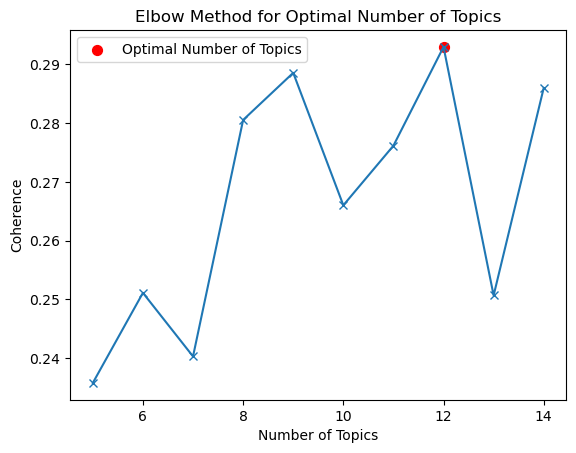

Optimal Number of Topics (Optimal Number of Topics): 12


In [18]:

# Plot the evaluation metric values against the number of topics
plt.plot(num_topics_range, eval_metric_values, marker='x')
plt.title('Coherence plot for Optimal Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')  

# Identify the elbow point using differences in coherence values
max_coherence_index = eval_metric_values.index(max(eval_metric_values))
optimal_num_topics = num_topics_range[max_coherence_index]
max_coherence_value = eval_metric_values[max_coherence_index]

# Mark the highest coherence value on the plot
plt.scatter(optimal_num_topics, max_coherence_value, c='red', label='Optimal Number of Topics', marker='o', s=50)
plt.legend()

plt.show()

# Print the identified optimal number of topics
print(f"Optimal Number of Topics (Optimal Number of Topics): {optimal_num_topics}")

Refit LDA Model with optimal number of topics

In [20]:
# Refit with optimal topics
lda = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=20)
lda.fit(X_filtered)

LatentDirichletAllocation(n_components=12, random_state=20)

Display the top 10 words for each topic

In [21]:
# Display the top 10 words for each topic in the refitted lda-model.
feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

print("Top words for each topic:")
for topic_id, topic in enumerate(lda.components_):
    # Get the indices of the top 10 words for the current topic
    top_word_indices = topic.argsort()[:-11:-1]
    # Get the actual words from the feature names
    top_words = feature_names[top_word_indices]
    print(f"Topic {topic_id + 1}: {', '.join(top_words)}\n{'-'*50}")

Top words for each topic:
Topic 1: research, study, ha, paper, analysis, system, social, data, tool, also
--------------------------------------------------
Topic 2: network, model, neural, feature, performance, code, method, deep, detection, proposed
--------------------------------------------------
Topic 3: quantum, model, theory, system, equation, field, state, solution, energy, function
--------------------------------------------------
Topic 4: galaxy, star, mass, source, emission, cluster, observation, model, data, find
--------------------------------------------------
Topic 5: model, mass, energy, particle, data, result, dark, star, neutrino, solar
--------------------------------------------------
Topic 6: learning, data, model, graph, network, training, method, task, domain, performance
--------------------------------------------------
Topic 7: state, phase, quantum, magnetic, field, material, effect, temperature, system, transition
-----------------------------------------

## Zero-Shot classification on a subset of 100,000 randomly extracted abstracts from the arXiv dataset

Load data for Zero-Shot classification

In [ ]:
# Specify the path to JSON Lines file
file_path = 'Arxiv_data/arxiv-abstracts.jsonl.gz'

# Setting seed for reproducibility
random.seed(42)

# Open the gzipped JSON Lines file
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    # Read a random subset of abstracts
    sample_size = 100000 
    data = [json.loads(line) for line in random.sample(file.readlines(), sample_size)]

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()
print(df.shape)

Zero-Shot classification and result analysis

In [ ]:
#Define a function for zero-shot classification
def zero_shot(abstracts, labels, gpu_index=0, random_seed=42):
    # Create a list of dictionaries where each dictionary contains an abstract and labels
    input_data = [{'abstract': abstract, 'labels': labels} for abstract in abstracts]

    # Initialize an empty list to store results
    results = []

    # Use the 'dataset' parameter to process the inputs in parallel on the chosen GPU
    classifier = pipeline('zero-shot-classification', device=gpu_index)
    
    # Use tqdm to create a progress bar
    for data_point in tqdm(input_data, desc="Processing Abstracts"):
        result = classifier(data_point['abstract'], data_point['labels'])
        results.append(result)

    return results

# Extract abstracts and define labels for zero-shot classification
abstracts = df['abstract'].tolist()
labels = ['nlp', 'natural language processing', 'Named Entity Recognition', 'NER', 'Sentiment Analysis', 'Text Classification']

# Set GPU index for zero-shot classification
gpu_index = 0

# Perform zero-shot classification on the abstracts
classification_results = zero_shot(abstracts, labels, gpu_index)

# Create a list to store DataFrames
dfs = []

# Populate the list with DataFrames for each abstract and label
for i, abstract in enumerate(abstracts):
    row = {'Title': df['title'].iloc[i], 'Abstract': abstract}
    for j, label in enumerate(labels):
        row[f'{label}_Score'] = classification_results[i]['scores'][j]
    df_row = pd.DataFrame([row])
    dfs.append(df_row)

# Concatenate the list of DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
result_df

Displaying top results after sorting by 'nlp_Score'

In [ ]:
# Sort the DataFrame based on the 'nlp_Score' column in descending order
result_df = result_df.sort_values(by='nlp_Score', axis=0, ascending=False)

# Create a subset DataFrame with selected columns
result_df_subset = result_df[['Title', 'Abstract', 'nlp_Score']]
result_df_subset.head()